In [26]:
# Third-party Library Imports
import numpy as np
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)

# Local Imports
from modules import forecast

# IPython Magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read SCM & ERA data

In [37]:
scm_era = pd.read_csv("files/ERA/processed/era_scm_final_features.csv")

# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
unique_scm = [c for c in scm_era.model.unique().tolist() if c != "ERA"] 
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

# preview
scm_era.sample(2)

,year,model,init_month,yield anomaly [%],tmeansquared_-38_-62_11,tmeanrain_-38_-62_11,rainsquared_-31_-61_11,rainsquared_-36_-62_9,tmeanrain_-31_-61_10
352,2003,DWD,10,0.084566,-0.100294,0.042219,-0.032996,0.36895,0.098299
717,2016,ECMWF,9,0.065329,-0.132994,0.009492,-0.053106,0.31388,0.533646


### 2. Train yield model and validate for each SCM

In [45]:
# Store results
results_r2 = pd.DataFrame(0.0, index=unique_scm, columns=[6, 7, 8, 9, 10, 11])
results_rmse = pd.DataFrame(0.0, index=unique_scm, columns=[6, 7, 8, 9, 10, 11])
predictions = pd.DataFrame(data={"year":list(range(1993,2017)), "yield anomaly [%]":scm_era.loc[scm_era["model"] == "ERA"].sort_values(by="year")["yield anomaly [%]"].unique()})
for month_of_initialization in init_months + [12]:
    for scm in unique_scm:
        res, _ = forecast.kfold_cross_validation(scm_era, model=scm, init=month_of_initialization, augment=False, no_of_features=4)
        # store performance
        results_rmse.loc[scm, month_of_initialization] = np.round(100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False), 4)
        results_r2.loc[scm, month_of_initialization] = np.round(r2_score(res["yield anomaly [%]"], res["predicted"]), 4)
        # store predictions
        res = res.rename(columns={"predicted":"predicted_{}_{}".format(scm, month_of_initialization)})
        predictions = predictions.merge(res[["year", "predicted_{}_{}".format(scm, month_of_initialization)]], on="year")

#### 2.1 Restructure result dataframes

In [46]:
results_r2 = results_r2.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"R2"})
#results_r2.loc[results_r2["R2"] < 0, "R2"] = 0
results_rmse = results_rmse.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"RRMSE [%]"})

(results_rmse
 .loc[results_rmse["init_month"] != 12]
 .pivot_table(index="model", columns="init_month", values="RRMSE [%]", sort=False)
 .merge(results_r2
        .loc[results_r2["init_month"] != 12]
        .pivot_table(index="model", columns="init_month", values="R2", sort=False), left_index=True, right_index=True, suffixes=("_RRMSE", "_R2"))
 .transpose()["3-MME"]
 )

init_month
6_RRMSE     13.2551
7_RRMSE     13.1616
8_RRMSE     13.3988
9_RRMSE     14.5817
10_RRMSE    11.7590
11_RRMSE    10.7909
6_R2         0.0344
7_R2         0.0479
8_R2         0.0133
9_R2        -0.1686
10_R2        0.2400
11_R2        0.3600
Name: 3-MME, dtype: float64

In [35]:
results_r2 = results_r2.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"R2"})
#results_r2.loc[results_r2["R2"] < 0, "R2"] = 0
results_rmse = results_rmse.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"RRMSE [%]"})

(results_rmse
 .loc[results_rmse["init_month"] != 12]
 .pivot_table(index="model", columns="init_month", values="RRMSE [%]", sort=False)
 .merge(results_r2
        .loc[results_r2["init_month"] != 12]
        .pivot_table(index="model", columns="init_month", values="R2", sort=False), left_index=True, right_index=True, suffixes=("_RRMSE", "_R2"))
 .transpose()["4-MME"]
 )

init_month
6_RRMSE     13.4423
7_RRMSE     12.7412
8_RRMSE     13.4014
9_RRMSE     14.7060
10_RRMSE    11.7296
11_RRMSE    10.7140
6_R2         0.0069
7_R2         0.1078
8_R2         0.0129
9_R2        -0.1886
10_R2        0.2438
11_R2        0.3691
Name: 4-MME, dtype: float64

#### 2.2 Create Figure 2

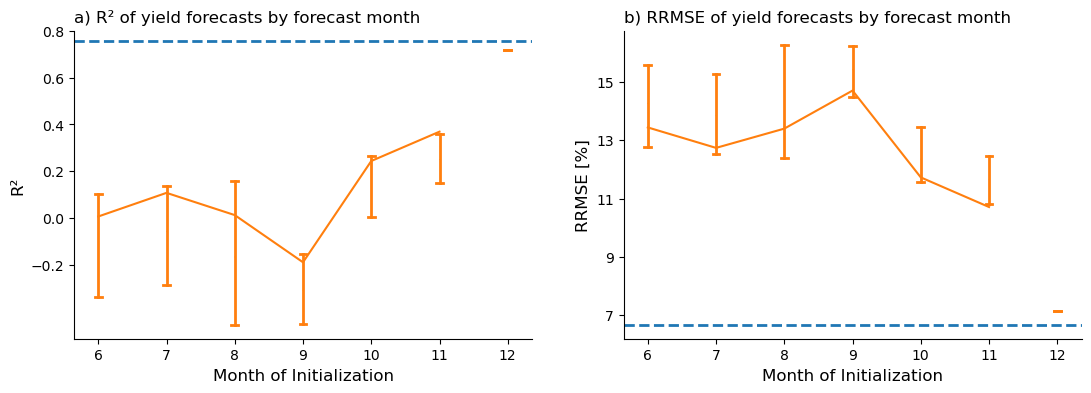

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(13,4))
axs = axs.ravel()

data1 = results_r2.loc[(results_r2["model"] != "4-MME")]
data1b = results_r2.loc[(results_r2["model"].isin(unique_scm))]

#sns.pointplot(data1b,  x="init_month", y="R2", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="grey", errwidth=2, ax=axs[0])
sns.pointplot(data1,  x="init_month", y="R2", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="#FF7F0E", errwidth=2, ax=axs[0])

data2 = results_r2.loc[(results_r2["init_month"] != 12) & (results_r2["model"] == "4-MME")]
data2.loc[:, "init_month"] = data2["init_month"].replace({6:0, 7:1, 8:2, 9:3, 10:4, 11:5})
sns.lineplot(data2, x="init_month", y="R2", color="#FF7F0E", ax=axs[0])
axs[0].set_title("a) R\u00b2 of yield forecasts by forecast month", loc="left", fontsize=12)
axs[0].set_xlabel("Month of Initialization", fontsize=12)
axs[0].set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])
axs[0].set_ylabel("R\u00b2", fontsize=12)
axs[0].axhline(0.7556, 0, color="#1F77B4", linestyle="--", linewidth=2)
axs[0].spines[['right', 'top']].set_visible(False)

data1 = results_rmse.loc[(results_rmse["model"] != "4-MME")]
data1b = results_rmse.loc[(results_rmse["model"].isin(unique_scm))]
#sns.pointplot(data1b,  x="init_month", y="RRMSE [%]", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="grey", errwidth=2, ax=axs[1])
sns.pointplot(data1,  x="init_month", y="RRMSE [%]", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="#FF7F0E", errwidth=2, ax=axs[1])
data2 = results_rmse.loc[(results_rmse["init_month"] != 12) & (results_rmse["model"] == "4-MME")]
data2.loc[:, "init_month"] = data2["init_month"].replace({6:0, 7:1, 8:2, 9:3, 10:4, 11:5})
sns.lineplot(data2, x="init_month", y="RRMSE [%]", color="#FF7F0E", ax=axs[1])
axs[1].set_title("b) RRMSE of yield forecasts by forecast month", loc="left", fontsize=12)
axs[1].set_xlabel("Month of Initialization", fontsize=12)
axs[1].set_ylabel("RRMSE [%]", fontsize=12)
axs[1].set_yticks(list(range(7, 16, 2)))
axs[1].axhline(6.68, 0, color="#1F77B4", linestyle="--", linewidth=2)
axs[1].spines[['right', 'top']].set_visible(False)

#plt.savefig("files/figures/figure4.png");
plt.show();


### 4. Visualize forecasts by year for Figure 5

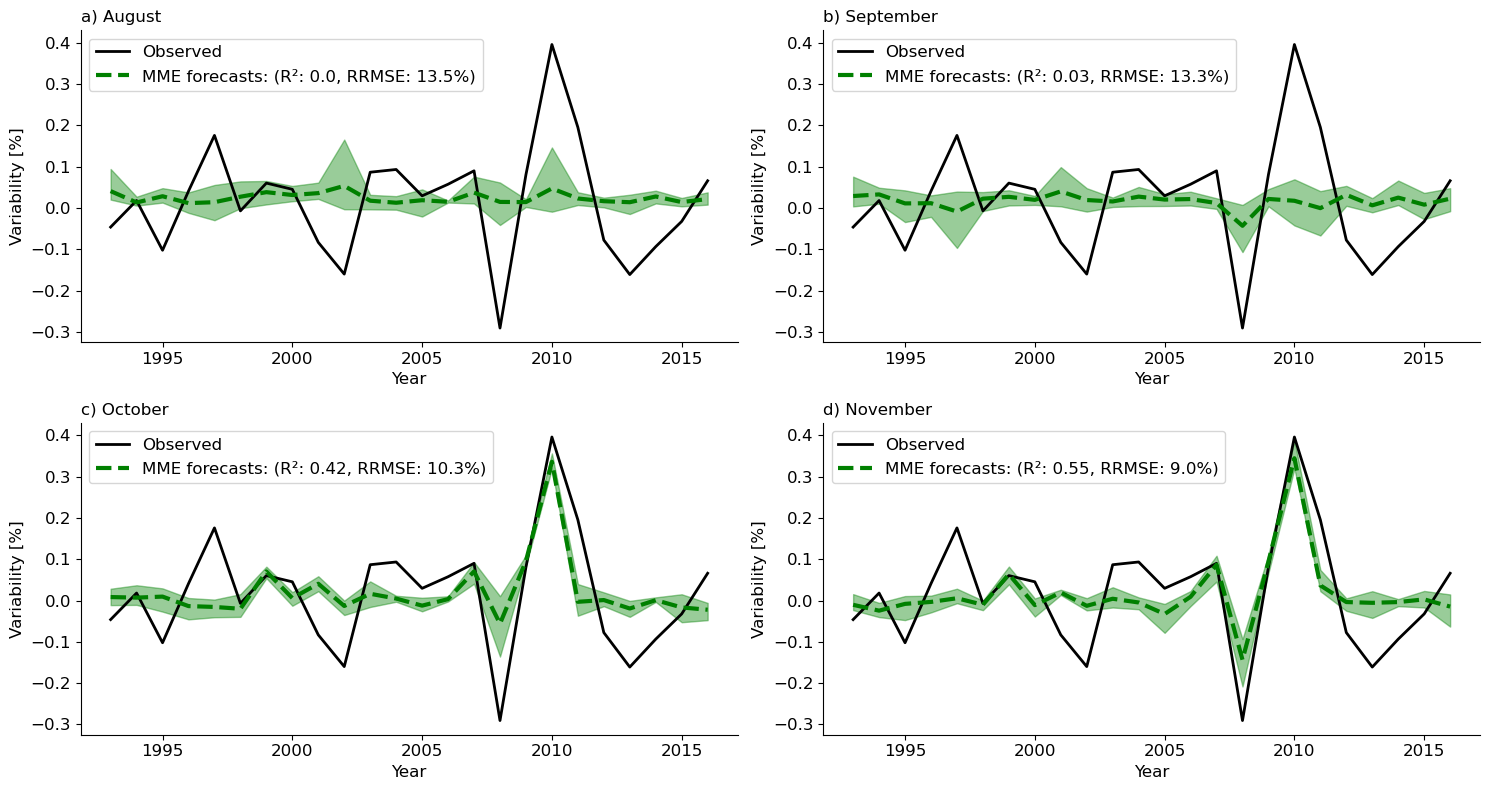

In [78]:
fig, axs = plt.subplots(2,2, figsize=(15,8))
axs = axs.ravel()

titles = dict(zip([8, 9, 10, 11], ["a) August", "b) September", "c) October", "d) November"]))
for im in list(range(8, 12)):
    plot_all = predictions.loc[:, ["year", "yield anomaly [%]", "predicted_ECCC_12"] + [c for c in predictions.columns if str(im) in c]].set_index("year")
    plot_all = plot_all.rename(columns={"predicted_ECCC_12":"estimated", "yield anomaly [%]":"observed"})
    min_values = plot_all[[c for c in plot_all.columns if str(im) in c]].min(axis=1).values
    max_values = plot_all[[c for c in plot_all.columns if str(im) in c]].max(axis=1).values
    mme_r2 = np.round(results_r2.loc[(results_r2["init_month"] == im) & (results_r2["model"]=="5-member-MME"), "R2"].values[0], 2)
    mme_rrmse = np.round(results_rmse.loc[(results_rmse["init_month"] == im) & (results_rmse["model"]=="5-member-MME"), "RRMSE [%]"].values[0], 1)
    mme_label = "MME forecasts: (R\u00b2: {}, RRMSE: {}%)".format(mme_r2, mme_rrmse)
    sns.lineplot(data=plot_all, x=plot_all.index, y=plot_all["observed"], linewidth=2, color="black", label="Observed", alpha=1, ax=axs[4+(im-12)])
    sns.lineplot(data=plot_all, x=plot_all.index, y=plot_all["predicted_5-member-MME_{}".format(im)], linewidth=3, color="green", 
                 label=mme_label, linestyle="--", ax=axs[4+(im-12)])
   
    
    axs[4+(im-12)].fill_between(plot_all.index, min_values, max_values, color="green", alpha=0.4)
    axs[4+(im-12)].set_xlabel("Year", fontsize=12)
    axs[4+(im-12)].set_ylabel("Variability [%]", fontsize=12)
    #ax.set_ylim(1.9, 3.3)
    axs[4+(im-12)].xaxis.set_tick_params(labelsize=12)
    axs[4+(im-12)].yaxis.set_tick_params(labelsize=12)
    axs[4+(im-12)].legend(fontsize=12)
    name = str(titles[im])
    axs[4+(im-12)].set_title(name, loc="left")
    axs[4+(im-12)].spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()
plt.savefig("files/figures/figure5.svg")
plt.show()